# 신용카드 부정 사용자 검출

데이터 특성
- target 데이터 중 1(Fraud)비율이 0.172% 밖에 없어 불균형이 극심함
- 컬럼명은 다른 이름으로 바뀌어져 있음

In [1]:
import pandas as pd 

data_path = './creditcard.csv'

raw = pd.read_csv(data_path)

raw.head()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
raw['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

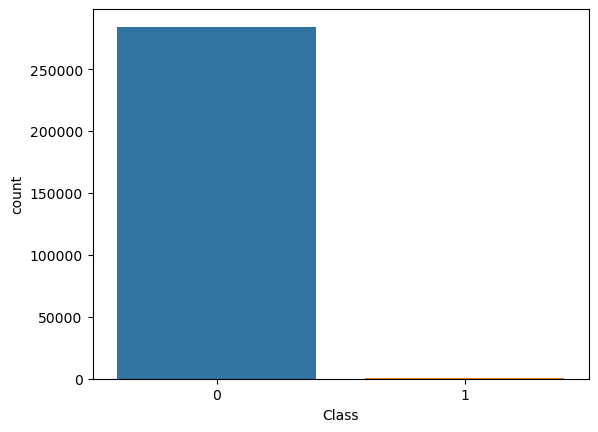

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=raw, x = 'Class');


In [5]:
raw.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
X = raw.iloc[:,1:-1]
Y = raw.iloc[:,-1]

X.shape, Y.shape

((284807, 29), (284807,))

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=13,stratify=Y)

나눈 데이터의 불균형 정도 확인 - 처음 0.17%와 같아야함

In [8]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([227451,    394], dtype=int64))

In [13]:
print(np.unique(y_train,return_counts=True)[1][1] / len(y_train) * 100, '%')

0.17292457591783889 %


## 1. 첫번째 시도 

In [15]:
# 먼저 분류기의 성능을 return하는 함수 하나 작성

from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score)

def get_clf_eval(y_test,pred):
    acc= accuracy_score(y_test,pred)
    presicion = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred)

    return acc,presicion,recall,f1,auc


In [16]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    acc,presicion,recall,f1,auc = get_clf_eval(y_test,pred)

    print('===Confusion matrix')
    print(confusion)
    print('====================')

    print('Accuracy: {0: .4f}, Presicion: {1: .4f}'.format(acc,presicion))
    print('Recall: {0: .4f}, F1: {1: .4f}, AUC: {2: .4f}'.format(recall,f1,auc))


In [18]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([56864,    98], dtype=int64))

In [17]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test,lr_pred)

===Confusion matrix
[[56856     8]
 [   40    58]]
Accuracy:  0.9992, Presicion:  0.8788
Recall:  0.5918, F1:  0.7073, AUC:  0.7958


주목할 수치는 Recall이다. 현재 59%정도로 성능이 좋지 않음

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13,max_depth=4 )
dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test,dt_pred)

===Confusion matrix
[[56856     8]
 [   33    65]]
Accuracy:  0.9993, Presicion:  0.8904
Recall:  0.6633, F1:  0.7602, AUC:  0.8316


아까보다는 수치가 올라갔지만 좀 더 해보자

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_estimators=100, n_jobs=-1)
rf_clf.fit(X_train,y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test,rf_pred)

===Confusion matrix
[[56857     7]
 [   25    73]]
Accuracy:  0.9994, Presicion:  0.9125
Recall:  0.7449, F1:  0.8202, AUC:  0.8724


In [21]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=13, n_estimators=1000, n_jobs=-1,num_leaves=64, boost_from_average=False)
lgbm_clf.fit(X_train,y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test,lgbm_pred)

===Confusion matrix
[[56858     6]
 [   24    74]]
Accuracy:  0.9995, Presicion:  0.9250
Recall:  0.7551, F1:  0.8315, AUC:  0.8775


### 조금 더 보충

In [22]:
#모델과 데이터를 주면 성능을 출력하는 함수 

def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)

    return get_clf_eval(y_test, pred)

In [23]:
#다수 모델의 성능을 정리해서 DF으로 반환하는 함수

def get_result_pd(models,models_name, X_train, y_train, X_test, y_test):
    col_names = ['accuracy','precision','recall','f1','roc_auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model,X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=models_name)

In [25]:
import time

models = [lr_clf,dt_clf,rf_clf,lgbm_clf]
models_name = ['LogisticReg','DecisionTree','RandomForest','LightGBM']

start_time = time.time()

result = get_result_pd(models,models_name, X_train, y_train, X_test, y_test)

print('Fit time:',time.time() - start_time)
result

Fit time: 239.66330289840698


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.999157,0.878788,0.591837,0.707317,0.795848
DecisionTree,0.999280,0.890411,0.663265,0.760234,0.831562
RandomForest,0.999438,0.912500,0.744898,0.820225,0.872387
LightGBM,0.999473,0.925000,0.755102,0.831461,0.877498


## 2. 두번째 시도

Amount 컬럼 확인

C:\Users\user\AppData\Local\Temp\ipykernel_12320\2764604907.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw['Amount'], color='r');


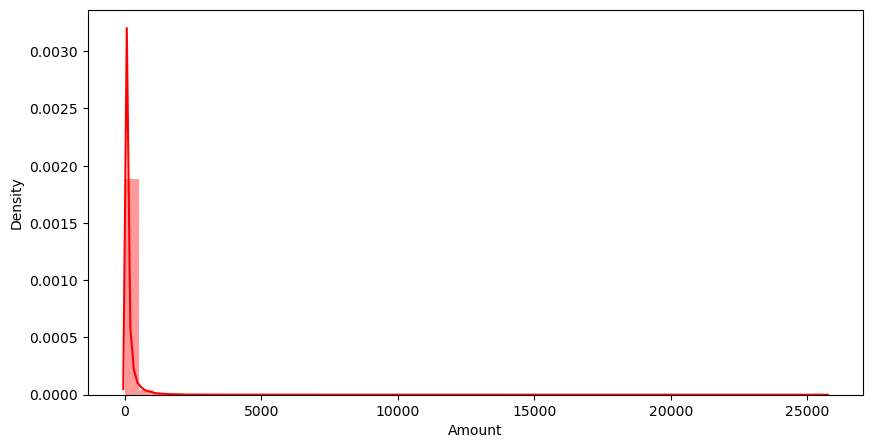

In [27]:
plt.figure(figsize=(10,5))
sns.distplot(raw['Amount'], color='r');

컬럼의 분포가 특정 대역에 몰려있다. 만약이 특성이 결과에 중요한 변수라면
우리는 이 컬럼을 스케일링할 필요가 있다. 

In [28]:
raw['Amount'].values.reshape(-1,1)

array([[149.62],
       [  2.69],
       [378.66],
       ...,
       [ 67.88],
       [ 10.  ],
       [217.  ]])

In [29]:
#스케일링 하여 새로운 컬럼추가
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
amount_n = scaler.fit_transform(raw['Amount'].values.reshape(-1,1))
raw_copy = raw.iloc[:,1:-2]
raw_copy['Amount_Scaled']=amount_n
raw_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [30]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(raw_copy,Y,test_size=0.2,random_state=13,stratify=Y)

모델 다시 평가하기

In [31]:
import time

models = [lr_clf,dt_clf,rf_clf,lgbm_clf]
models_name = ['LogisticReg','DecisionTree','RandomForest','LightGBM']

start_time = time.time()

result = get_result_pd(models,models_name, X_train, y_train, X_test, y_test)

print('Fit time:',time.time() - start_time)
result

Fit time: 228.89541864395142


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.999157,0.878788,0.591837,0.707317,0.795848
DecisionTree,0.999280,0.890411,0.663265,0.760234,0.831562
RandomForest,0.999438,0.912500,0.744898,0.820225,0.872387
LightGBM,0.999473,0.925000,0.755102,0.831461,0.877498


모델별로 roc 커브도 그려보자

In [32]:
from sklearn.metrics import roc_curve

def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10,10))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:,1]
        fpr, tpr , thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr ,label=model_names[model])
    
    plt.plot([0,1],[0,1],'k--', label = 'random guess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

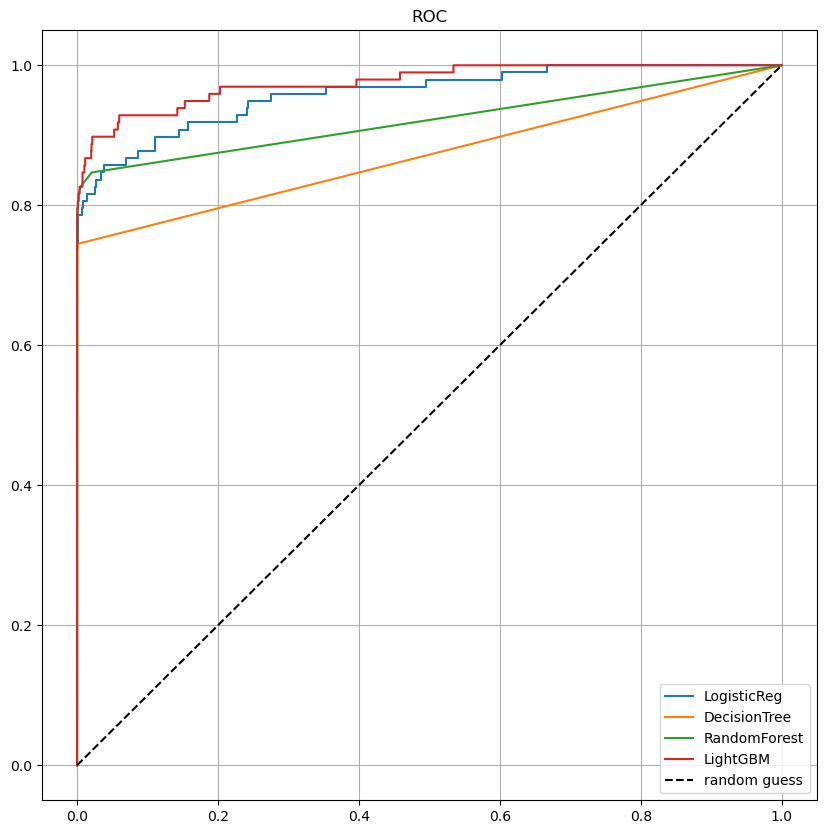

In [33]:
draw_roc_curve(models,models_name,X_test,y_test)

### 좀 더 보충 - log scale

In [34]:
amount_log = np.log1p(raw['Amount'])

raw_copy['Amount_Scaled'] = amount_log

C:\Users\user\AppData\Local\Temp\ipykernel_12320\1579991247.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_copy['Amount_Scaled'], color='r');


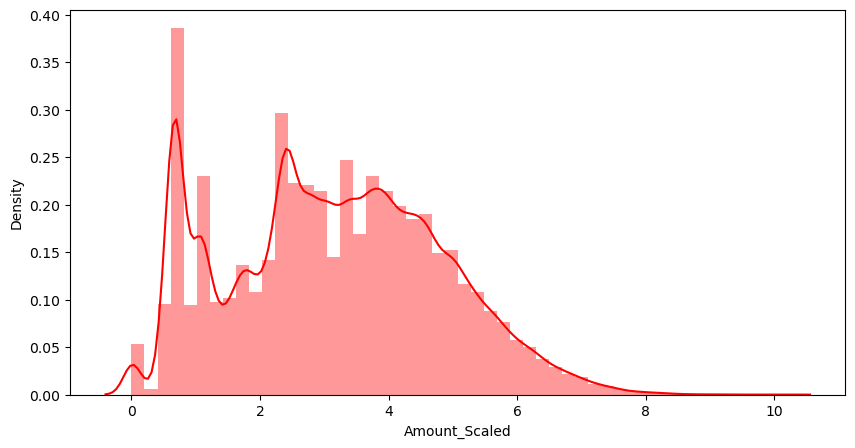

In [35]:
plt.figure(figsize=(10,5))
sns.distplot(raw_copy['Amount_Scaled'], color='r');

다시 모델 평가

In [36]:
X_train,X_test,y_train,y_test = train_test_split(raw_copy,Y,test_size=0.2,random_state=13,stratify=Y)

In [37]:
models = [lr_clf,dt_clf,rf_clf,lgbm_clf]
models_name = ['LogisticReg','DecisionTree','RandomForest','LightGBM']

start_time = time.time()

result = get_result_pd(models,models_name, X_train, y_train, X_test, y_test)

print('Fit time:',time.time() - start_time)
result

Fit time: 218.41318106651306


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.999157,0.878788,0.591837,0.707317,0.795848
DecisionTree,0.999280,0.890411,0.663265,0.760234,0.831562
RandomForest,0.999438,0.912500,0.744898,0.820225,0.872387
LightGBM,0.999473,0.925000,0.755102,0.831461,0.877498


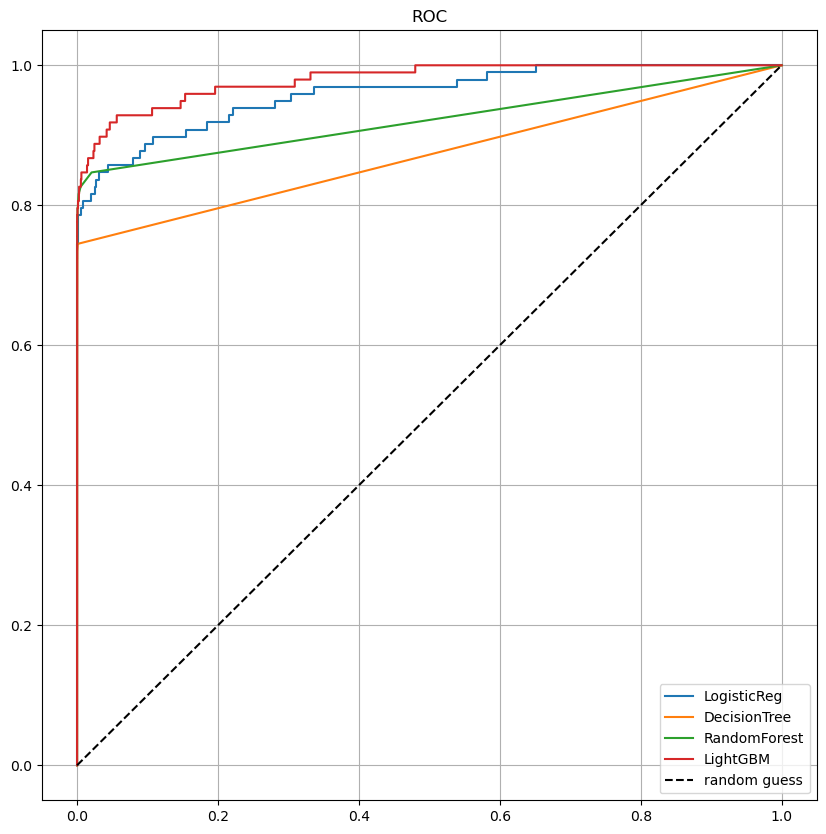

In [38]:
draw_roc_curve(models,models_name,X_test,y_test)

## 3.세번쨰 시도 _Outlier

In [39]:
#outlier를 정리하기 위해 outlier의 인덱스를 파악하는 코드

def get_outlier(df=None, column=None, weight = 1.5):
    fraud = df[df['Class']==1][column]

    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud >highest_val)].index

    return outlier_index

In [40]:
get_outlier(df=raw, column='V14')

Index([8296, 8615, 9035, 9252], dtype='int64')

In [41]:
#Outlier 데이터 제거
outlier_index = get_outlier(df=raw, column='V14')
raw_copy.drop(outlier_index, axis=0 ,inplace=True)
raw_copy.shape

(284803, 29)

In [44]:
Y = raw.iloc[:,-1]
Y.drop(outlier_index, axis=0 ,inplace=True)

In [45]:

X_train,X_test,y_train,y_test = train_test_split(raw_copy,Y,test_size=0.2,random_state=13,stratify=Y)

models = [lr_clf,dt_clf,rf_clf,lgbm_clf]
models_name = ['LogisticReg','DecisionTree','RandomForest','LightGBM']

start_time = time.time() 

result = get_result_pd(models,models_name, X_train, y_train, X_test, y_test)

print('Fit time:',time.time() - start_time)
result

Fit time: 195.9715714454651


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.999333,0.905405,0.683673,0.779070,0.841775
DecisionTree,0.999491,0.879121,0.816327,0.846561,0.908067
RandomForest,0.999631,0.913978,0.867347,0.890052,0.933603
LightGBM,0.999719,0.955556,0.877551,0.914894,0.938740


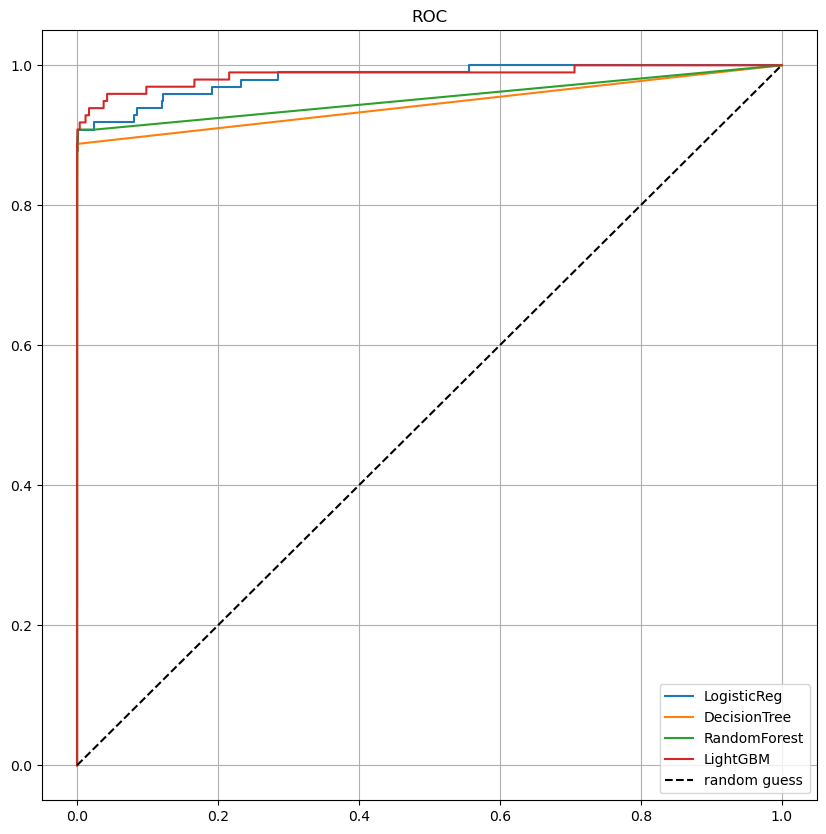

In [46]:
draw_roc_curve(models,models_name,X_test,y_test)

outlier를 제거하니 recall이 좋아졌다.

## 4.네번째 시도_ SMOTE oversampling

In [47]:
!pip install imbalanced-learn

   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/258.3 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 3.1 MB/s eta 0:00:00


In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)

X_train_over, y_train_over = smote.fit_resample(X_train,y_train)

***중요한 점 : 스케일러를 제외하고, 원칙적으로 train데이터에 한 변경들을 test데이터에 하면 안된다***

In [49]:
X_train_over.shape, y_train_over.shape

((454904, 29), (454904,))

In [51]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([227452,    390], dtype=int64))

데이터 수가 불어난 것을 확인

In [52]:
np.unique(y_train_over, return_counts=True)

(array([0, 1], dtype=int64), array([227452, 227452], dtype=int64))

In [53]:

models = [lr_clf,dt_clf,rf_clf,lgbm_clf]
models_name = ['LogisticReg','DecisionTree','RandomForest','LightGBM']

start_time = time.time() 

result = get_result_pd(models,models_name, X_train_over, y_train_over, X_test, y_test)

print('Fit time:',time.time() - start_time)
result

Fit time: 359.60228991508484


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.973385,0.056320,0.918367,0.106132,0.945924
DecisionTree,0.969944,0.049665,0.908163,0.094180,0.939107
RandomForest,0.999614,0.887755,0.887755,0.887755,0.943781
LightGBM,0.999561,0.876289,0.867347,0.871795,0.933568


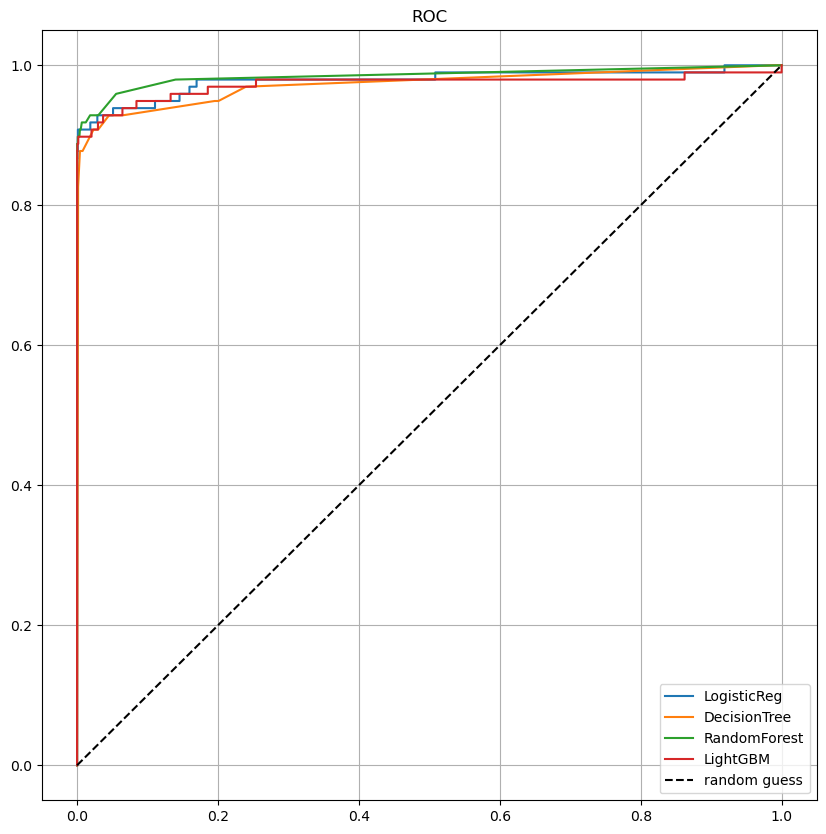

In [54]:
draw_roc_curve(models,models_name,X_test,y_test)